## Datasets

### Trespass Towing Report
https://data.montgomerycountymd.gov/Consumer-Housing/Trespass-Towing-Report/i6vn-3s6e/about_data

### Places
https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Census-Tract-Data-GIS-Friendly-Format-2024-/yjkw-uj5s/about_data

### EPA Smart Locations
https://www.epa.gov/system/files/documents/2023-10/epa_sld_3.0_technicaldocumentationuserguide_may2021_0.pdf

### Social Vulnerability Index
https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2022.html

### USDA Food Access Research Atlas
https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/

In [1]:
import pandas as pd
# Trespass Towing Report
tows = pd.read_csv('Trespass_Towing_Report.csv',
                   parse_dates=['Incident Date', 'Tow Date'])
# Proprietary Complaints Data
complaints = pd.read_csv('FY24 Trespass Tow Complaints(FY24 Trespass Tow Cases).csv',
                         parse_dates=['Create Date', 'Assigned Date', 'Closed Date'],
                         encoding='latin-1')
# CDC Places
places = pd.read_csv('PLACES__Census_Tract_Data.csv')
# EPA Smart Locations
locations = pd.read_csv('EPA_SmartLocationDatabase.csv')
# Social Vulnerability Index
svi = pd.read_csv('Maryland_SVI.csv')
# USDA Food Access Research Atlas
#access = pd.read_csv('FoodAccessResearchAtlasData2019.csv')
# Census Income Data
#income = pd.read_csv('household_income.csv')

# Suppress scientific notation (for the GEOID)
pd.options.display.float_format = '{:.0f}'.format

In [ ]:
complaints

## Preparing Geo Data

### GEOIDS for Complaint Addresses

https://walker-data.com/pygris/04-geocoding/

In [ ]:
# Takes 2.5 minutes to run
from pygris.geocode import geocode

complaints['geoid'] = 0

i = 0
while i < len(complaints):
    try:
       complaints.loc[i,'geoid'] = geocode(address=complaints.loc[i, 'Tow Location']).iloc[0, 2]
       print('yay' + str(i)) 
    except:
        pass
        print('oops' + str(i))
    i += 1

### Census GEOIDs
https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

**Maryland FIPS:** 24
**Montgomery County FIPS:** 031

In [2]:
# Filter Datasets for Montgomery County
places_MD = places[places['StateAbbr'] == 'MD']
places_MC = places_MD[places_MD['CountyName'] == 'Montgomery']

locations_MD = locations[locations['STATEFP'] == 24]
locations_MC = locations_MD[locations_MD['COUNTYFP'] == 31]

# CensusTract = TractFIPS
access_MD = access[access['State'] == 'Maryland']
access_MC = access_MD[access_MD['County'] == 'Montgomery County']


NameError: name 'access' is not defined

In [4]:
access_MC.head()

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
30243,24031700101,Maryland,Montgomery County,1,4321,1393,0,0,0,0,...,559,3407,342,306,1,19,246,305,0,60
30244,24031700103,Maryland,Montgomery County,0,5864,1862,0,42,1,0,...,666,4189,536,811,3,21,304,457,2,35
30245,24031700104,Maryland,Montgomery County,1,5356,1843,0,0,0,0,...,410,3011,1314,487,1,9,534,886,8,205
30246,24031700105,Maryland,Montgomery County,1,6528,2056,0,0,0,0,...,319,3362,1395,1016,4,18,733,1211,0,113
30247,24031700204,Maryland,Montgomery County,0,2124,754,0,16,1,0,...,297,1885,59,22,1,11,146,208,0,16


In [2]:
# Extract Tract FIPS from GEOID
tows['TractFIPS'] = tows['geoid'].astype(str).str.slice(0,-6)
#complaints['TractFIPS'] = complaints['geoid'].astype(str).str.slice(0,-4)

In [4]:
# Filter for relevant columns
places_MC = places_MC[['TractFIPS', 'TotalPopulation', 
                       'BINGE_CrudePrev', 'DISABILITY_CrudePrev',
                       'FOODSTAMP_CrudePrev', 'FOODINSECU_CrudePrev',
                       'HOUSINSECU_CrudePrev', 'LACKTRPT_CrudePrev']]

locations_MC = locations_MC[['CountHU', # Housing Units (2018)
                             'HH', # Households (2018)
                             'AutoOwn0', # Auto Ownership (2018)
                             'Pct_AO0', # Percent of households with an automobile (2018)
                             'D2a_JpHH', # Percent zero car households (2018)
                             'D4a', 
                             'D4e',
                             'D1a', # Gross residential density (HU/acre) on unprotected land
                             'D1b', # Gross population density (persons/acre) on unprotected land
                             'D1c', # Gross employment density(jobs/acre) on unprotected land
                             'D1d' # Gross activity density (employment + HUs) on unprotected land
                             ]] 



KeyError: "['D2a_JpHH', 'D4a', 'D4e', 'D1a', 'D1b', 'D1c', 'D1d'] not in index"

In [10]:
places_MC['TractFIPS'] = places_MC['TractFIPS'].astype(str)

tows_merge = tows.merge(places_MC, left_on='TractFIPS', right_on='TractFIPS', how='left', validate='m:1')


In [3]:
tows_per_day = tows.groupby('Incident Date').count()

In [ ]:
tows.head()


## Household Income Data

In [7]:
income.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Unnamed: 0,Total Households,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more"
Census Tract 7001.01; Montgomery County; Maryland!!Estimate,"1,576",60,40,21,0,4,0,29,27,0,53,108,84,145,90,337,578
Census Tract 7001.03; Montgomery County; Maryland!!Estimate,"1,851",2,0,84,2,50,39,3,2,23,10,51,157,201,134,236,857
Census Tract 7001.04; Montgomery County; Maryland!!Estimate,"1,699",25,66,10,29,22,15,19,11,18,64,274,225,132,135,208,446
Census Tract 7001.05; Montgomery County; Maryland!!Estimate,"2,141",31,10,15,0,55,53,14,15,0,60,244,179,364,209,493,399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Census Tract 7060.09; Montgomery County; Maryland!!Estimate,"1,699",33,7,0,52,8,19,0,31,0,28,50,39,106,136,202,988
Census Tract 7060.10; Montgomery County; Maryland!!Estimate,"1,112",7,0,28,11,0,18,64,9,9,16,39,97,50,48,237,479
Census Tract 7060.11; Montgomery County; Maryland!!Estimate,"1,817",6,19,10,20,16,0,11,0,63,30,98,93,66,64,145,"1,176"
Census Tract 7060.12; Montgomery County; Maryland!!Estimate,"1,845",110,121,32,82,19,78,43,35,74,110,183,260,139,80,199,280


## Cleaning Tow Reasons

In [3]:
# No parking (catch-all?)
spell_PKG = ['PKG', 'PGK', 'PKGG', 'NO PKG', 'NO PARKING', 'PKNG', 'NO PKNG', 'PARKED IN GRASS', 'PARIKING VIO', 'PARKING VIOLATION',
             'NO PKG ZONE', 'PRK', 'PARKED IN NO PARKING ZONE', 'PARKED ON THE GRASS', 'NO PARKING ZONE', 'UNAUTH PKG',
             'UNAUTHORIZED PARKING', 'NO PK ZONE', 'NPKG', 'PK', 'PKG`', 'PARKED OVER 2 HR LIMIT', 'ILLEGALLY PARKED ON GRASS',
             'NOT PARKED IN MARKED SPACE', 'NOT IN PARK SPACE', 'NOT PAKED IN MAKRED SPACE']
# Handicap space
spell_HANDI = ['HANDICAP', 'HANICAP SPACE', 'HANDICAPPED VIOLATION', 'HANDICAP PKG', 'HANDICAP PARKING', 'HAND', 'HANDY' 'IN HANDICAP',
               'PARKED IN HANDICAP', 'HADNICAP', 'HANDICAP VIOLATION', 'HADNICAPP', 'HANDI', 'PARKED IN HANDICAP WITH INVALID HANDICAP PERMIT']
# Fire lane
spell_FIRE = ['FIRE', 'FIRELANE PARKING', "FIRE LANE", "FIRELAND NO PARKING ZONE", 'FIER', 'FIR', 'FIRE LANE AND BLOCKING ACCESS',
              'FIRE LN', 'FR', 'FIRELANE', 'FIRE LA', 'FIRE LANE VIOLATION']
# No overnight parking
spell_NOP = ['NOP', 'NO', 'NO OVERNIGHT PARKING', 'NO[', 'VISITOR VIOLATION / NOP', 'NOPP', 'NO WALK OFF/ NO OVERNIGHT PARKING',
             'NO OVERNIGHT PKH', 'OVERNIGHT', 'NPO', 'NOPN', 'NO OVER NIGHT PARKING', 'UNAUTHORIZED PARKING - NO OVERNIGHT PARKING',
             'NOP`', 'RESERVED PKG NOP', 'MOP', 'NO OVERNIGHT PKG']
# Private Property
spell_PVT = ['PVT', 'PRV PROP', 'PRI', 'PRIV PROP', 'PRVV', 'PRV PREOP', 'PRT PROP', 'PRIVATE PROPERTY', 'PRVT', 'PRV PROPERTY', 'PRV',
             'PRIVATE PROP' 'PRIVATE', 'PRV PROP', 'PRIV  PROP', 'PRV PROERTY', 'PRIV PROPERTY', 'PVI', 'PR', 'PRIVATE PROP	', 'PRIV',
             'PRIVATE PROP	']
# Abandoned Vehicle
spell_ABAN = ['ABN', 'ABAN', 'ABAN AUTO', 'ABAND AUTO', 'ABND AUTO', 'ABN AUTO', 'ABD', 'ABANDON', 'ABANDONED', 'ABAND', 'ABANDON AUTO', 
              'ABANDONED AUTO']
# Repossesion
spell_REPO = ['REPO', 'REP', 'REOP', 'IMPOUND', 'IMP', 'REPOSSESSION']
# Expired Tags or Permit
spell_EXP = ['EXP', 'EXP PERMIT', 'EXP TAGS', 'EXP PERMIT', 'EXP  PERMIT', 'EXP TAG', 'EXP PASS', 'EXP REGISTRATION']
# Disabled Vehicle
spell_DAV = ['DAV', 'INOPERABLE', 'IN-OPERABLE', 'IMOBLE', 'IN OPERABLE VEH ', 'IN OPERABLE VEH', 'IMMOBILE CAR']
# Walk off
spell_WALK = ['WALK', 'WALK OFF', 'WALKOFF', 'WALK-OFF']
# Management request
spell_MNG = ['MNG', 'MANAGEMENT REQUEST', 'MGMT', 'MANAGEMENT REQ', 'UNAUTHORIZED PKG BY MANAGEMENT', 'MANAGER REQUEST', 'MGR REQ']
# Stolen
spell_ST = ['STOLEN']
# Fake permit
spell_FAKE = ['FAKE']
# Unpaid
spell_UNPAID = ['UNPAID', 'UNPAID PKG', 'NOT PAYING ON THE PARKING APP', 'NOT PAYING TO PARK']
# No permit
spell_NOPERMIT = ['NO PERMIT']
#Invalid permit
spell_INVPERMIT = ['INVALID PERMIT', 'INV PERMIT', 'INVALID PERMIT DISPLAYED', 'ALTERED PERMIT', 'FAKE PARKING PERMIT', 'INVALID PERMIT COUPLE YEARS OLD',
                   'INVALID DISPLAY OF PERMIT']
# Visitor parking issues
spell_VISIT = ['VISIT', 'VISITOR', 'EXP GUEST PASS', 'EXP VISITOR PERMIT', 'NO VIST PERMIT', 'INVALID PERMIT - VISITOR IN RESD SPOT ', 
               'INVALID PERMIT - VISITOR IN RESD SPOT', 'NO VIST PERMIT', 'VISITOR PARKED IN RESIDENT SPOT', 'RESIDENT PARKED IN VISITOR SPOT', 
               'INVALID PERMIT - VISITOR IN RESD SPOT ', 'EXP VISITOR PASS', 'EXP GUEST PASS', 'NO VISITOR PERMIT', 'EXP VISITOR PERMIT',
               'VISTOR PARKED IN RESD PARKING', 'VISITOR PARKED IN RESIDENT SPOT']
# Double parking
spell_DBL = ['DBL', 'DOUBLE PARKED', 'DBL PARKED', 'PARKED IN 2 SPACES', 'PARKED IN TWO SPACES', 'VEHICLE PARKED IN MULTIPLE SPACES',
             'TAKING UP TWO PARKING SPACES', 'TAKING 2 SPACES', 'TAKING UP 2 SPACES', 'TAKING UP TWO SPACES']

# Tow reason abreviations
spell_REASON = [spell_PKG, spell_FIRE, spell_NOP, spell_PVT, spell_ABAN, spell_REPO, spell_HANDI, spell_EXP, spell_DAV, spell_WALK,
                spell_MNG, spell_ST, spell_FAKE, spell_UNPAID, spell_NOPERMIT, spell_INVPERMIT, spell_DBL, spell_VISIT]

In [4]:
# Non-towing reasons in tow reasons column
not_reasons = ['HENRYS', '72', 'N', 'P', 'TCL', 'DIVERSIFY', 'DIVERSIFIED', 'TOW', '72HR', 'AUTH', 'HENRY', "HENRY'S TOWING", 'POL',
               'BIG TOW', 'MISC', 'VOP', 'PARKING', 'INV', 'COUNTY IMPOUND']
# Goes through 'Tow Reason' and 'Notes' columns to parse out true tow reasons
def find_reason(spell_R):
    # When the 'Tow Reason' is NaN
    if pd.isnull(row['Tow Reason']):
        # If notes is empty
        if pd.isnull(row['Notes']):
            tows.loc[index, 'Reason for tow'] = "Unknown"
        # If notes include reason
        elif any(spell in row['Notes'].upper() for spell in spell_R):
            tows.loc[index, 'Reason for tow'] = spell_R[0] # First spelling in each list is correct
    # If reason is spelled alternatively
    elif row['Tow Reason'].upper() in spell_R:
        tows.loc[index, 'Reason for tow'] = spell_R[0]
    # If reason is not a reason (error inputting variables)
    elif row['Tow Reason'].upper() in not_reasons:
        if pd.isnull(row['Notes']):
            tows.loc[index, 'Reason for tow'] = "Unknown"
        elif any(spell in row['Notes'].upper() for spell in spell_R):
            tows.loc[index, 'Reason for tow'] = spell_R[0]

# Loop through all the spellings
for spell in spell_REASON:
    for index, row in tows.iterrows():
        find_reason(spell)

In [7]:
sum(tows['Reason for tow'].isna())

871

In [8]:
tows.head()

,Unnamed: 0,Tow Date,Vehicle Year,Vehicle Make,Vehicle Model,Tow Reason,Storage Company,Notes,Incident Date,Location,City,Geo-location field,coord,lon,lat,geoid,TractFIPS,Reason for tow
0,0,2023-10-27,2021,MERZ,NaN,NOP,HENRYS,NaN,2023-10-27,3421 HEWITT AVE,SILVER SPRING,POINT (-77.069720978 39.078605989),-77.069720978 39.078605989,-77,39,240317032141004,24031703214,NOP
1,1,2023-11-24,2023,DODG,CHA,NOP,SPEEDY,NaN,2023-11-24,8560 2ND AVE,SILVER SPRING,POINT (-77.032605995 38.996120016),-77.032605995 38.996120016,-77,39,240317025032002,24031702503,NOP
2,2,2024-06-25,2024,TOYT,HGH,PKG,AUTHORIZED,FIRELANE,2024-06-25,8800 LANIER DR,SILVER SPRING,POINT (-77.048472016 38.999848999),-77.048472016 38.999848999,-77,39,240317027005015,24031702700,PKG
3,3,2023-10-18,2021,HYUN,ELN,PKG,TCL,HENRYS 301 927 0007 UNAUTH/WALK OFF TCL,2023-10-18,10105 COLESVILLE RD,SILVER SPRING,POINT (-77.011794987 39.020445011),-77.011794987 39.020445011,-77,39,240317021022019,24031702102,PKG
4,4,2024-06-10,2015,JEEP,WRG,FIRE,tcl,FIRE HENRYS 301-869-4800 TCL,2024-06-10,8510 16TH ST,SILVER SPRING,POINT (-77.040972978 38.998122997),-77.040972978 38.998122997,-77,39,240317026023000,24031702602,FIRE


In [ ]:
tows[tows['Reason for tow'].isna()].head(55)

## Cleaning Up Trade Names

In [9]:
# A1 Parking Management
spell_A1 = ['A1 Parking Management', 'A1', 'A1 PARKING', 'A1 PGK MNG', 'A1 PKG MGT', 'A1 PKG MANAGEMENT', 'A1 PARKING MANAGEMENT', 'A1 PKG MNG',
            'A1 PARKING MGMT', 'A1 PKG MGMT', 'A1 PKG', 'A1 PARKIGN', 'A-1 PARKING MNGT', 'A-1', 'A - 1', 'A ONE', '3014773521',
            'A ONE PARKING', 'A1-TOW', 'A1 TOWING', 'A ONE TOWING', '301 477 3521', 'AONE', 'AI Parking Management', '81 PARKING MANAGEMENT',
            'A1 PKG MANAGMENT', 'A1 PARK MGT', 'A1 PARK MGMT', 'A1 PRIVATE INVEST', 'A1 PROPERTY MGMT', 'AI PARKING MANAGEMENT']
# A & G Auto Service
spell_AG = ['A & G Auto Service', 'A & G AUTO SERVICE', 'AMG RECOVERY']
# Airpark Autobody
spell_AIR = ['Airpark Autobody', 'AIRPARK', 'AIRPARK TOWING', 'AIR PARK', 'AIRPAIR TOWING', 'AIR PARK TOW', '301-948-7997', '948-7997']
# AKJ Towing
spell_AKJ = ['AKJ Towing','AKJ', '301-774-0595']
# A & M Auto Service Inc.
spell_AM = ['A & M Auto Service Inc.', 'A & M AUTO SERVICE INC', 'AM TOWING', 'A&M', 'A AND M', '3014210953', '301-421-0953', '301.421.0953', '301 421 0953',
            'A&M TOWING', 'A&M 301 421 0953']
#Auburn Towing, Inc.
spell_AUB = ['Auburn Towing, Inc.', 'AUBURN', 'AUBURN TOWING', 'AUBURN TOW', 'AUBBURN', 'AUBRUN', 'AUBRURN', 'AIUBURN', 'A UBURN', 'AUBRUN TOWIN',
             'AUBUBRN', 'AUBRUN TOWING', 'AURBURN', 'AUBURB', 'AUBURNTOWING', 'AUBURBN', '301-977-2740']
# Automotive Support Services
spell_AUTO = ['Automotive Support Services', '301-384-4869']
#Big Tow
spell_BIG = ['Big Tow', 'BIG TOW', 'BIG', 'BIG TOW TOWING', 'BIGTOW', 'BIG TOWING', 'BIG BIG TOW', 'BIG TOE', 'BG TOW', 'BIGTOW TOWING', 'BIG TOWN', 
             'BGTOW', 'BOG TOW', 'BIG TOWI']
#Diversified Recovery
spell_DIVERS = ['Diversified Recovery', 'DIVERSIFIED', 'DIVERSIFED', 'DIVERSIFIED TOWING', 'DIVERSFIED', 'DIVERSITY TOWING', 'DIVERSIFY RECOVERY', 'DIVERSIFIED 301-881-8035',
                'DIVERSIFY', 'DIVERSIFIED TOWING AND RECOVERY', 'DIVERSFD', 'DIVERISFIED', 'DIVERSIFIED RECOVERY', 'DIVERSIIED',
                'DIVERSIFIED TOW', '301-881-8035', 'DIVIERSIFIED TOW', 'DIVERSFY', 'DIVIERSIFIED', 'SUBVERSIFIED', 'DIVERSIDIED', 'DIVERISIFIED', 
                'DIVER', 'DIVERS', 'DIVERS', 'DIVERSERIFED', 'DEVERSIFIED', 'DIVERDIFIED', 'DIVERIFISED', 'DIVERSERIFED TOWING', 'DIVERSIFED TOWING',
                'DIVERSIFIFED', 'DIVIRSIFIED TOW', 'DOVERSIFIED']
# E & S Towing Service
spell_ES = ['E & S Towing Service', 'E& S TOWING', 'E&S', 'E & S', 'E AND S TOWING', 'E & S TOWING', 'ES TOWING', 'E&S TOWING', 'E/S', 'E AND S',
            '240 304 9367', '2403049367', '240-304-9367', '240-304-9467']
# Grace Towing and Recovery, LLC
spell_GRACE = ['Grace Towing and Recovery, LLC', 'GRACE TOWING', 'GRACE TOW AND RECOVERY', 'GRACE TOW', 'GRACE TOWING AND RECOVERY', 'GRACE', 'GRACE TOWING & RECOVERY',
               'GRACE RECOVERY', 'GRACES']
# Henry's Wrecker Service
spell_HENRY = ["Henry's Wrecker Service", 'HENRYS', 'HENRYS TOW', "HENRY'S", "HENRY'S TOWING", "HERNYS", "HENRYS'", 'HENRYS`', "HENRY'S TOWINH"
               'HENRY', "HENRY'S TOWINH", 'HENRYS TOWING', 'HEN','HNERYS', 'HENYRS', "HENYR'S", "HENRYS'", '3019270007',
               'HENRY"S', '301 869 4800', "HERNY'S TOWING", 'HENRY', 'HERNSY', "HNERY'S", '301-869-4800', 'HENERYS TOWING', "HENRY'S`", 'HE NRYS',
               'HNERYS TOWING', 'HENREYS', 'HEBRYS', 'FHENRYS', 'HENRY;S', 'HENRY TOWING', "HENRY'SC", 'HNERYS TOWING', '3018694800',
               'HENERYS', "HENRY'S LOT", 'HENRS', 'HENRYD', 'HENRYS TOWNING', 'HENRYS TWOING', 'HENRYSS', "HERNY'S", "HENRY'S TOW", 'HENRYS TOWINF',
               'HERNY', '301-927-0007']
# K & D Towing
spell_KD = ['K&D', 'K & D', '301-399-9225', 'K AND D', 'K AND D TOWING', 'K&D TOW', 'K&D TOWING', 'K N D TOWING', 'KD TOWING', 'KND',
            'KND TOWING''K & D TOWING', 'KND TOWING', '301 755 4450', 'K & D TOWING', 'KD', 'A&D', 'K AND B', '3017554450', 'KANDD', 'KAND TOWING',
            'A&D TOWING', 'K &D', 'K & D  TOWING', 'K& D', '301 755 1450', '301-755-4450']
# L.L. Towing
spell_LL = ['L.L. Towing', 'LL TOWING', '(301) 774-3342', '301 774 3342', '301-774-3342']
# Lofton's Towing & Transport
spell_LOFT = ["Lofton's Towing & Transport", 'LOFTONS', 'LOFTONS TOW', 'LOFTONS TOWING', 'LOFTON TOWING', "LOFTON'S", 'LOFTON', 'LOFTON TOW',
              '240-388-1389', 'LAWFTONS', 'LAWSON TOWING', 'LAWSONS', '2403881389']
#Metro Investigation & Recovery Solutions
spell_METRO = ['Metro Investigation & Recovery Solutions', 'METRO INV', 'METRO INVEST', 'METRO INVESTIGATIONS', 'METRO INVESTIGATONS', 'MET INV', 'MET INVEST', 'METRO IN', 'METRO INC',
               'METRO', 'METRO INVESTIGATION', 'METRO I NV', 'METRO INVSETIGATIONS', 'METRO INVESTIGATIONS TOWING', 'METRO INV & REC',
               'METOR INVESTIGATION', 'METRO INVESTIGAQTIONS', 'METRO INVESTIGAT',  'METRO INV TOW', 'MERTO INV', 'METRO INV & RECOVERY',
               'METRO  INV', 'METRO INVESTGIATION', 'METRO INVSTIGATIONS', 'METRO INVES','METRO INVESTIIGATIONS', 'METRO INV RECOV', 'METRO INV.',
               'METRO INVESTIGATIONS TOW', 'METRO INVESTGATIONS', 'METRO INVEST TOW', 'MERO INV', 'METOR', 'METERO', '1101 GALASKY HWY',
               'METRO INVEST.', 'METRO INVESTIAGTION', 'METRO INVESTIG', 'METRO INVESTIGATION AND RECOVERY', 'METRO INVESTIGATION RECOV', 'METRO INVESTIGATIOS',
               'METRO INVS', 'METRO INVSETIGATION', 'METRO INVST', 'METRO INVSTEGATIONS', 'METRO TOWING', 'METROINVESTIGATIONS', 'METRO INVESTAGATION',
               'FINAL NOTICE', 'FINAL NOTICE TOW LOT', 'FINALNOTICE', '410-344-1501', 'METO INV']
# Millers's Towing & Recovery, LLC
spell_MILLER = ["Millers's Towing & Recovery, LLC", "MILLER'S TOWING & RECOVERY, LLC", 'MILLERS', 'MILELRS', "MILLER'S TOWING", 'MILLER S', 'MILLERS TOWING', 'MILLER', "MILLER'S", 'MILLERSS',
                'MILLERS TOW', ',ILLERS', 'MILLER TOWING', "MILER'S", 'MILILERS', 'MILLESR', 'MILLERSQ', "MILLER'S TOWING AND RECOVERY", 'MILLERS TOWING AND RECOVERY',
                'MILLERS TOWING & RECOVERY', 'MILLERS & RECOVERY', 'MILLER WOTING', 'MILL.ERS', 'MILLERS RECOVERY', '301-602-0392']
# Montrose Towing
spell_MON = ['Montrose Towing', 'MONTROSE TOWING', 'MONTROSE']
# Morton's Towing & Recovery, Inc.
spell_MORT = ["Morton's Towing & Recovery, Inc.", 'MORTONS TOWING', 'MORTONS', "MORTON'S", 'MOTENS', ' 301-330-1170', "MORTIN'S", 'MORTON', 'MORTANS', 
              '3013301170']
# N & S Towing
spell_NS = ['N & S Towing', 'NS TOWING', 'N & S TOWING']
# Ricky's Towing & Recovery, LLC
spell_RICK = ["Ricky's Towing & Recovery, LLC", "RICKY'S", 'RICKYS', 'RICKYS TOWING', "RICKEY'S", 'RICKEYS', 'RICKY', "RICKY'S TOWING", 'RICKYS TOW', 
              'RICKSY', 'RICKSYS', 'RICKY TOW', 'RICKIES', "RICKY'S  TOWING", "RICK'YS", 'RICKEY', 'RICK', 'RICKYSTOWING', 'RICYS TOWING']
# Scott Simpson Towing
spell_SCOTT = ['Scott Simpson Towing', 'SCOTT SIMPSON TOWING', 'SCOTTS SIMPSON TOWING', 'SCOTT SIMPSON', '301 476 9090', 'SST TOWING']
# Silver Spring Towing and Recovery
spell_SILV = ['Silver Spring Towing and Recovery', 'SILVER SPRING TOWING', '301-589-7878', 'SS TOWING', '301 589-7878', '(301)589-7878', '301 589 7878',
              'SILVER SPRING TOW', '2406876994', '3015897878']
# Speedy Towing
spell_SPEEDY = ['Speedy Towing', 'SPEEDY', 'SPEEDYS', 'SPEEDY TOWING', 'SPEEDY TOW', 'SPEEYING', 'SPEEEDY', 'SPEEYD', 'SPEEDY TOWIG',
                'SPEEDY TOWNG', 'SPEEDYS TOWING', 'SPEEDING TOWING', 'SPEDDY', 'S[PEEDY', '301-588-1322', 'SPEDDY TOWING', 'SPEDDY',
                'SPEDY', 'SPOEDY', 'SPEEDSY', 'SPEEDYS`', 'SPEEDSY', "SPEEDY'S", 'SILVER SPRING', 'SPEEDY LOT']
#Stronghold Towing
spell_STR = ['Stronghold Towing', '301-916-0660', 'STRONGHOLD']
#Werking Automotive
spell_WERK = ['Werking Automotive', 'WERKING', '301-916-0455', '3019160455', 'WERKING TOWING']

# Ambiguous/unsure trade names
# All Towing Service LLC
spell_ALL = ['All Towing Service LLC', '240-528-1171', 'RD TOWING']
# AMJ Recovery Service?
spell_AMJ = ['AMJ Recovery Service?', 'AMJ', 'AMJ RECOVERY', 'AMJ RECOV', 'AMJ TOWING']
# Asikin Towing?
spell_ASI = ['Asikin Towing', '301-530-2888', 'ASIKIN TOWING', 'ASKIN', 'ASIKIN', 'ASKIN TOWING']
# AT Auto Transort?
spell_AT = ['AT Auto Transport', '240-529-9839']
# Authorized?
spell_AUTH = ['Authorized?', 'AUTHORIZED', 'AUHTORIZED', 'AUTH', 'AUTHORIZED TOWING', 'AUTHORIIZED', 'AUTHOZIED TOWING '
              'AUTHORIZE TOW', 'AUTHORIZE', 'AUTHORIZE TOE', 'AUTHORZIED', 'AUTHROIZED','AUTHORIZED TOWNG',
              'AUHTORIZED TOWING', 'AUTORIZED TOWING', 'AUTHORIZE TOWING', 'AUTHRORIZED', 'AUTH', 'AUJTHORIZED',
              'AUTHTORIZED', 'AUTHORIRZED', 'AUTHORZED', '301-562-4020', 'AUTORIZED', 'AUTHORIZIED', 'ATUHORIZED',
              'AUTHROZIED', 'AUTHORIZED TOWIN', 'AUTHORUIZED', 'AUTHORIZED`', 'AUTHROZIED TOWING', 'AUTH`', '301-562-4020',
              'AUTHORIZE TOW', '16327', 'ATHORIZED', 'AUTHORIZE TOW', 'AUTHORIZZED', 'AUTHORUZED', 'AUTHOTIZED',
              'AUTHPRUIZED', 'AURHORIZED', 'AUTHOIRZED', 'AUTHOIZED', 'AUTHORIE TOWING', 'AUTHORIZE TOW', 'AUTHORIZEED',
              'AUTHOZIED', 'AUTHOZIED TOWING', 'AUTHPRIZED', 'AUTOHERIZED', 'AUTHORIZED TOW', '31-562-4020']
# Balto Auto Sales?
spell_BALT = ['Balto Auto Sales', '443-770-0320']
# Bill Hallet's Towing?
spell_BILL = ["Bill Hallet's Towing", ]
# Cherner?
spell_CHER = ['Cherner?', 'CHERNER BROTHERS', 'CHERNER BROTHER', 'CHERNER', 'CHERNER BROS', '301-949-9095', 'CHERNER BROTHERS`']
# Cody Towing?
spell_CODY = ['CODY TOWING', 'CODY', 'CODY TOWING AND RECOVERY', 'CODYS', '3014734322']
# CTI?
spell_CTI = ['CTI Towing?', 'CTI', 'CTI TOWING', '301-772-2998', '301 772 2998', 'CIT', 'CTI RECOVERY']
# Custom Towing & Auto Repair
spell_CUST = ['Custom Towing & Auto Repair', '301-253-5151', 'CUSTOM TOWING', '301 253 5151', 'CUSTOM', 'CUSTOMS', 'CUSTOMS TOWING']
# Drive?
spell_DRIVE = ['Drive?', 'DRIVE TOW', 'DRIVE TOWING', '(301) 585-8808', '301-585-8808', '301 585 8808', '(301)585-8808',
               '301585 8808', 'DRIVE']
# EC?
spell_EC = ['EC?', 'EC TOWING', 'EC TOW', '202 603 9543', '240-382-2621', '240 382 2621', '202-603-9543', 'EASY', 'EC 301 603 9503'
            'EASY TOWING', 'E&C', 'E&C TOWING', 'E-C TOWING', 'E Z TOWING', 'EC', 'EZ TOWING', 'EASY TOWING', 'E C TOWING', 'EC 301 603 9503',
            'E.C.', 'EC TOWNG','EZ']
# ETC Recovery?
spell_ETC = ['ETC Recovery?', 'ETC', 'ETC RECOV', 'ETC RECOVERY', 'ETC TOWING']
# Fast Guys Towing & Roadside Assistance?
spell_FAST = ['Fast Guys Towing & Roadside Assistance', 'FAST GUYS', 'FAST GUY', 'FAST', 'FAST GUYS TOWING', 'FASTCAR']
# GTS Towing?
spell_GTS = ['GTS Towing', '703-462-0447']
# Greenwood Recovery?
spell_GREEN = ['Greenwood Recovery?', 'GREENWOOD RECOVERY', 'GREENWOOD', 'GREENWOOD RECOV', 'GREENWOOWD REC', 'GREEWOOD', 'GRNWOOD', 
               'GRNWOOD RECOV', '410-383-8000', '410 383 8000']
# JH Recovery LLC?
spell_JH = ['JH Recovery LLC?', 'JH', 'JH RECOV', 'JH RECOVERY', 'JH TOWING']
# JNJ Towing & Recovery?
spell_JNJ = ['JNJ Towing & Recovery', '240-708-5399']
# LED?
spell_LED = ['LED?', 'LED TOW', 'LED TOWING', 'LED RECOVERY', 'LED', '301-556-8006', 'LED TOWIN', '301 556 8006']
# L & K?
spell_LK = ['L&K?', 'L&K RECOVERY', 'L&K TOW', 'L AND K TOWING', 'L&K RECOVERY', 'LK RECOVERY', 'LMK RECOVERY', 'LK COMPANY',
            'LNK RECOVERY', 'L AND K', 'L & K RECOVERY', 'L&K', 'L AND K RECOVERY', 'LNK', '703-327-5600', 'L & K', 'L& K', 'L&K RECOV', 
            'LNK', 'L&K ROCVOERY', 'L&K TOWING', 'L&L RECOVERY', 'LNT TOWING', 'L AND K']
# Late Nite Towing?
spell_LN = ['Late Nite Towing?', '240-602-4944', 'LATE NIGHT TOWING', 'LATE NITE TOWING', 'LATE NIGHT']
# LTS Repossession?
spell_LTS = ['LTS Repossession?', 'LTS', 'LTS RECOVERY']
# Milestone Towing & Transport?
spell_MILE = ['Milestone Towing & Transport', 'MILESTONE', '301-330-1614']
# GTS Towing?
spell_GTS = ['GTS Towing?', '703-462-0447']
# On the Run Towing?
spell_OTR = ['On the Run Towing?', 'ON THE RUN', 'ON THE RUN TOW', 'ON THE RUN TOWING', 'ONTHERUN', '301-740-4600']
# Prestige?
spell_PRES = ['Prestige?', 'PRESTIGE', 'PRESTIGE TOW', 'PRESIGE', 'PRESTIGE TOWING', 'PRESITGE', 'PRES', 'PRESITGE', 'PRESTIGE'
              'PRESTAGE', 'PESTIGE', 'PRETSIGE', 'PRESTIEGE', 'PRESTAGE', 'PRESTIUGE', 'PRESTGE', 'PRESTEIGE', 'PRESTIVE',
              'PRESTIGE AUTO', 'PREISTIGE', 'PRSTIGE', '[RESTIGE', 'PRETIGE', 'P RESTIGE', 'PRISTIGE', '301-377-9285',
              'PRESTIAGE', 'RPESTIGE', 'PRESTIGE`', 'PREST IGE']
# RBF Towing?
spell_RBF = ['RBF Towing?', '(240) 793-2272', '240 793 2272', 'RBF', 'RBF TOWING', '240-793-2272', 'RDF TOWING', 'RVF TOWING']
# Roadmate Towing?
spell_ROAD = ['Roadmate Towing?', '240-641-2188']
# Thomas Recovery Inc?
spell_THOM = ['Thomas Recovery Inc', '410-247-0662', 'THOMAS RECOVERY', '410 247 0662', 'THOMAS', 'THOMASRECOVERY']
# TRP?
spell_TRP = ['TRP?', 'TRP', 'TRP TOWING']

# All spelling list names
spelling = [spell_A1, spell_AG, spell_ALL, spell_AIR, spell_AKJ, spell_AUB, spell_AUTH, spell_MILE,
            spell_AUTO, spell_BIG, spell_DIVERS, spell_DRIVE, spell_EC, spell_ES, spell_ASI, spell_ROAD,
            spell_GRACE, spell_HENRY, spell_KD, spell_METRO, spell_MILLER, spell_MORT, spell_BILL,
            spell_PRES, spell_RICK, spell_SILV, spell_SPEEDY, spell_LK, spell_LED, spell_TRP, spell_RBF,
            spell_LOFT, spell_MON, spell_GREEN, spell_AMJ, spell_CODY, spell_CUST, spell_OTR, spell_WERK,
            spell_AM, spell_LN, spell_SCOTT, spell_GREEN, spell_NS, spell_CTI, spell_LL,
            spell_STR, spell_AT, spell_FAST, spell_JNJ, spell_CHER, spell_THOM, spell_BALT, spell_GTS,
            spell_ETC, spell_JH, spell_LTS]


In [10]:
# Parses out merchant from 'Storage Company' and 'Notes' columns
def find_trade_name(spell_COMP):
    spell_alt = ['TCL', 'COUNTY LOT', 'TC;', 'TCK', 'TC:', 'COUNTY', 'VRS', "UNKNOWN",
                 'PKG', 'FIRE', 'NOP', 'PVT', 'ABAN', 'ABN', 'REPO', 'AAU', 'ABAN AUTO', 'ALLY', 'CAPITAL ONE',
                 'CAPITAL', 'CARMAX', 'CHASE', 'ENTERPRISE', 'ECC', 'HERTZ', 'PNC BANK', 'ROYAL TRUST',
                 'SANTANDER', 'STATE EMPL CREDIT', 'TCCL', 'TC:', 'TCKL', 'ONE MAIN', 'FLAGSHIP CREDIT',
                 'FLAGSHIP', 'ANDREWS FCU', 'ALLY', 'ALLY FINANCIAL', 'FIRST HELP FINANCIAL', 'OTHER',
                 'CREDIT ACCEPTANCE', 'AMERICAN HONDA FINANCE', 'AMERICAN HONDA', 'ANNAPOLIS JUNCTION', 
                 'AVS', 'BRIDGECREST', 'BRIDGECREST CREDIT', 'CREDIT ACCEPTANCE', 'CONSUMER', 'CREDIT UNION LLC',
                 'CT HOLDINGS', 'EXETER', 'EXETER FINANCE', 'EXP PERMIT', 'GLENMONT FINANCIAL', 'FRIENDLY',
                 'GM FIANCE', 'P&CC BANK', 'WELLS FARGO FINANCIAL', 'ALLIED FINANCIAL', 'ALLIED SOLUTIONS',
                 'AMERICAN', 'AMERICA HONDA', 'AMERICAN CREDIT ACCEPTANCE', 'AVAS RENTAL CAR', 'AVIS', 'AVIS LOT',
                 'AVIS RENTAL LOT', 'CHRS CAPITAL', 'FIANCE CO C/O TCL', 'FINANCE TO VIA TCL', 'KENSINGTON FINANCE', 
                 '1ST CORPORATION', '305 METROPOLITAN GROVE RD', '305 METROPOLITAN GROVE RD', '446 N FREDERICK ATV',
                 'HERTZ RENTAL', 'LOT', 'PRV', 'SANTANDER FINANCE', 'SS TCL', 'TC', 'WESTLAKE', 'TCLE', 'AAV',
                 '305 METROPOLITIAN GROVE RD', 'AM VRS', 'T CL', 'EXP TAGS', 'TCL;', 'TCL+', 'TL', 'TCLX',
                 'TCL 3013779285', 'TOYT', 'TCL- FINANCE CO', 'ALLIED', 'ALLIED BANK', 'AMERICAN CREDIT',
                 'AMERICAN CREIT', 'AMERICAN HOND', 'AUTO TRACK', 'AVAS RENTAL CAR', 'AVIS CAR RENTAL',
                 'AVIS LOT', 'AVIS RENTAL LOT', 'CHRY CAPITAL', 'COUNTY IMPOUND', 'CREDIT ACCEPTANCE', 'L'
                 'CREDITA FINANCE', 'CT HOLDINGS', 'HYUN CAPITAL', 'TCL`', 'TCL3018694800', 'TCLNE', 'TO ABN',
                 'TOYOTO FINANCIAL', 'TOYT FINANCIAL', 'WESTLAKE FINANCIAL', 'CBA FINANCE', 'CBAB FINANCE', 'CL',
                 'HERTZ RENT A CAR', 'HONDA FINACIAL', 'PNC', 'RIDGECREST', 'ES', 'EXITER', 'EXP', 'HON', 'INVALID PERMIT',
                 'LK', 'MERC BENZ', 'CTL', 'CAPITAL ONE BANK', 'CREDIT ACCEPTANCE', 'LANGLEY', 'LIENHOLDER LOT',
                 'LENDER LOT', 'LIENHOLDER LOT', 'AAV TOWING', 'ACCEPTANCE', 'FORUM CREDIT UNION', 'SECU', 'SPECTRA', 
                 'TC L', 'TCI', 'TLC', 'TOW', 'YVL', 'PAR', 'PAR SERVICES', 'PAR SVC', 'PAR SVCS', 'PAR SERVICES INC',
                 'PAR SERIVCES']
    # When the 'Storage Company' is NaN
    if pd.isnull(row['Storage Company']):
        if pd.isnull(row['Notes']):
            tows.loc[index, 'Trade Name'] = "Unknown"
        elif any(spell in row['Notes'].upper() for spell in spell_COMP):
            tows.loc[index, 'Trade Name'] = spell_COMP[0]
    # When the 'Storage Company' is not a company
    elif row['Storage Company'].upper() in spell_alt:
        if pd.isnull(row['Notes']):
            tows.loc[index, 'Trade Name'] = "Unknown"     
        elif any(spell in row['Notes'].upper() for spell in spell_COMP):
            tows.loc[index, 'Trade Name'] = spell_COMP[0]
    # When the 'Storage Company' is one of the spelled companies
    elif row['Storage Company'].upper() in spell_COMP:
        tows.loc[index, 'Trade Name'] = spell_COMP[0]
    # When the 'Storage Company' is abandoned??
    elif row['Storage Company'].upper() in spell_ABAN:
        if pd.isnull(row['Notes']):
            tows.loc[index, 'Trade Name'] = "Unknown"
        elif any(spell in row['Notes'].upper() for spell in spell_COMP):
            tows.loc[index, 'Trade Name'] = spell_COMP[0]

# Loop through all the spellings
for spell in spelling:
    for index, row in tows.iterrows():
        find_trade_name(spell)

## Cleaning Up Vehicle Make


In [12]:
# BMW
spell_BMW = ['BMW', 'BWM', 'BMQ', 'BMW`', 'BMX', 'MBMW']

# Faraday Future
spell_FF = ['Faraday Future']

# Ford
spell_FORD = ['Ford', 'FORD', 'FOR`', 'FIORD', 'FORD SIE', 'FORDF', 'FORD F15', 'FOR', 'FROD', 'FOD', 'FORF', 'FORS', 'FRD', 'FRDO']

# Lincoln
spell_LINC = ['Lincoln', 'LINC']

# Buick
spell_BUIC = ['Buick', 'BUIC']

# Cadillac
spell_CAD = ['Cadillac', 'CAD', 'CADI', 'CADILLAC']

# Chevrolet
spell_CHEV = ['Chevrolet', 'CHEV', 'CHEVROLET', 'CHEVR', 'CHEVY', 'CHEV`', 'CHEC', 'CEHV', 'CHEC', 'CHV', 'CHY']

# GMC
spell_GMC = ['GMC', 'GMC']

# Acura
spell_ACUR = ['Acura', 'ACUR', 'ACCU', 'ACC', 'ACURR', 'ACCUR', 'AC', 'ACR', 'ACU', 'ACUIR']

# Honda
spell_HOND = ['Honda', 'HOND', 'HONDA', 'HON', 'HIND', 'HON D', 'HODA', 'HONA', 'HIOND', 'HODN', 'HOD', 'HONC', 'HONND',
              'HONSD', 'HYOND', 'HOND`', 'HOMD', 'HON CIV', 'HOND`', 'HONE', 'HONS']

# Genesis
spell_GENE = ['Genesis', 'GENE', 'GENESIS', 'GENISES', 'GENISIS', 'GENR', 'GENI', 'GENS']

# Hyundai
spell_HYUN = ['Hyundai', 'HYUN', 'HYND', 'HYUNDAI', 'HYND', 'HYN', 'HYUIN', 'HYUND', 'HUYN', 'HYU', 'HYUNM', 'HYUY']

# Kia
spell_KIA = ['Kia', 'KIA', 'KIP', 'KAIS']

# Lucid
spell_LUCI = ['Lucid', 'LUCI']

# Mazda
spell_MAZD = ['Mazda', 'MAZD', 'MAXD', 'MAZDZ', 'MAZ', 'MADZ', 'MADZA', 'MADZ']

# Mercedes-Benz
spell_MERC = ['Mercedes-Benz', 'MERZ', 'MERCEDES', 'MERCEDES-BENZ', 'MERC', 'MERZZ', 'MERZQ', 'MERZ `']

# Infiniti
spell_INFI = ['Infiniti', 'INFI', 'INFIN', 'INFINI', 'INFO', 'INFT', 'INIF']

# Nissan
spell_NISS = ['Nissan', 'NISS', 'NISSAN', 'NIS', 'NISS ALT', 'NISSA', 'NISS SEN', 'NISSAN`', 'NIZ']

# Rivian
spell_RIVI = ['Rivian', 'RIVI']

# Dodge
spell_DODG = ['Dodge', 'DODG', 'DOG', 'DODGE', 'DOD', 'DOGE', 'DODE', 'DOGG']

# Jeep
spell_JEEP = ['Jeep', 'JEEP', 'JEP', 'JEPP', 'JEEE']

# Ram
spell_RAM = ['Ram', 'RAM', 'RAMB', 'RABB', 'RAMS']

# Subaru
spell_SUBA = ['Subaru', 'SUBA', 'SUBARU', 'SUBU', 'SUB']

# Tesla
spell_TESL = ['Tesla', 'TESL', 'TESLA', 'TES', 'TESI', 'TELSA']

# Lexus
spell_LEXU = ['Lexus', 'LEXU', 'LEXUS', 'LEXS', 'LEX', ',LEXS', 'LEXAS']

# Toyota
spell_TOYT = ['Toyota', 'TOYT', 'TOYO', 'TOYP', 'TOTY', 'TOYOT', 'TOYOTA', 'TOYT`CAM', 'TOTL', 'TOYR', 'TOTYT', 'TOYT`', 'YTOYT',
              'OTOTY', 'TOYTQ', 'TOYT CAM', 'TOY', 'TYT', 'TIOY', 'TOIYT', 'TOHYT', 'TOYTA', 'TYOT', 'TTOYT', 'TOYY', 'TTOYT', 
              'TOYY', 'TOYTY', 'TOYTO', 'TOYT1', 'TOYA', 'TOTT', 'TIOYT']

# Volkswagen
spell_VOLK = ['Volkswagen', 'VOLK', 'VOLKSWAGEN', 'VOLKS', 'VW', 'VLKS', 'VOL;K', 'VLK', 'VOLT', 'VOLS', 'VOK', 'VOLZ', 'VQ']

# Volvo
spell_VOLV = ['Volvo', 'VOLV', 'VOLVO', 'VOVL', 'VOOL', 'VOOL', 'VOV']

# Polestar
spell_POLS = ['Polestar', 'POLS', 'POLE']

# Audi
spell_AUDI = ['Audi','AUDI', 'AUBU', 'AUFI', 'AUID', 'AUFI', 'AYD']

# Mitsubishi
spell_MITS = ['Mitsubishi', 'MITS', 'MITZ', 'MITSUBISHI', 'MITSU', 'LANC', 'MITZU', 'MIST']

# Porsche https://en.wikipedia.org/wiki/List_of_Porsche_vehicles
spell_PORS = ['Porsche', 'PORS', 'PORSH']

# Suzuki
spell_SUZU = ['Suzuki', 'SUZU', 'SUZI', 'SUZ', 'SUZUKI', 'SUS', 'SUZ']

# Jaguar
spell_JAGU = ['Jaguar', 'JAGU']

# Chrysler https://en.wikipedia.org/wiki/List_of_Chrysler_vehicles
spell_CHRY = ['Chrysler', 'CHRY', 'CHRYSLER', 'CHRYS', 'CRY', 'CRYS']

# Scion https://en.wikipedia.org/wiki/List_of_Scion_vehicles
spell_SCION = ['Scion', 'SCION', 'SCIO', 'SION']

# Fiat
spell_FIAT = ['Fiat', 'FIAT', 'FIAA']

# Maserati https://en.wikipedia.org/wiki/List_of_Maserati_vehicles
spell_MAS = ['Maserati', 'MAS', 'MASERATI', 'MASE']

# Mini https://en.wikipedia.org/wiki/Mini_(marque)#Current_models
spell_MINI = ['Mini', 'MINI', 'MNNI', 'MINICOOPER', 'COOP', 'MINI COOPER']

# Saturn 
spell_SATU = ['Saturn', 'SATU', 'SATURN', 'SATR', 'STRN']

# Land Rover
spell_LAND = ['Land Rover', 'LAND', 'LANDR', 'LNDR', 'ROV', 'LANDROVER']

# Oldsmobile
spell_OLDS = ['Oldsmobile', 'OLDS']

# Pontiac
spell_PONT = ['Pontiac', 'PONT', 'POIN', 'PONI', 'PON']

# Hummer
spell_HUMM = ['Hummer', 'HUMM', 'HUMB', 'HUM']

# Freightliner
spell_FREI = ['Freightliner', 'FREI', 'FRHT', 'FREIGHTLINER', 'FRHT', 'FRIEIGHTLINER', 'FREIGHLINER', 'FRIGHT LINER']

# Saab
spell_SAAB = ['Saab', 'SAAB', 'SAA']

# International
spell_INTL = ['International', 'INTL', 'INTERNATIONAL']

# Geo
spell_GEO = ['Geo', 'GEO']

# Isuzu
spell_ISUZ = ['Isuzu', 'ISUZ', 'ISU', 'ISUZ', 'ISUZU', 'AZUZU']

# Smart
spell_SMRT = ['Smart', 'SMRT', 'SMART']

# Plymouth
spell_PLYM = ['Plymouth', 'PLYM']

# Alfa Romeo
spell_ALFA = ['Alfa Romeo', 'ALFA', 'ALFAROMEO', 'ALPH']

# Bentley
spell_BENT = ['Bentley', 'BENT']

# Kaufman Trailers
spell_KAUF = ['Kaufman Trailers', 'KAUF', 'KAUFMAN', 'KAU', 'KUFFMAN', 'COUFMAN']

# Hino Trucks
spell_HINO = ['Hino Trucks', 'HINO', 'HINO TRUCKS']

# Polaris
spell_POLR = ['Polaris', 'POLARIS']

# Citroen
spell_CITR = ['Citroen', 'CITR', 'CITROEN', 'CITROE', 'CITROEN']

# Peugeot
spell_PEUG = ['Peugeot', 'PEUG', 'PEUGEOT']


spelling_makes = [spell_BMW, spell_FF, spell_FORD, spell_LINC, spell_BUIC, spell_CAD, spell_CHEV, spell_GMC, spell_ACUR,
                  spell_HOND, spell_GENE, spell_HYUN, spell_KIA, spell_LUCI, spell_MAZD, spell_MERC, spell_INFI, spell_NISS,
                  spell_RIVI, spell_DODG, spell_JEEP, spell_RAM, spell_SUBA, spell_TESL, spell_LEXU, spell_TOYT, spell_VOLK,
                  spell_VOLV, spell_POLS, spell_AUDI, spell_MITS, spell_PORS, spell_SUZU, spell_JAGU, spell_CHRY, spell_SCION, 
                  spell_FIAT, spell_MAS, spell_MINI, spell_SATU, spell_LAND, spell_OLDS, spell_PONT, spell_HUMM, spell_FREI,
                  spell_SAAB, spell_INTL, spell_GEO, spell_ISUZ, spell_SMRT, spell_PLYM, spell_ALFA, spell_BENT, spell_KAUF,
                  spell_HINO, spell_POLR]



In [29]:
len(spelling_makes)

56

In [13]:

tows['make'] = 'none'

def find_vehicle_make(row, spell):
    if pd.isnull(row['Vehicle Make']):
        if pd.isnull(row['Vehicle Model']):
            if pd.isnull(row['Notes']):
                return "Unknown"
            elif any(s.upper() in row['Notes'].upper() for s in spell):
                return spell[0]
            else:
                return "Unknown"
        elif 'TRAILER' in row['Notes'].upper():
            return 'Trailer'
    elif row['Vehicle Make'].upper() in [s.upper() for s in spell]:
        return spell[0]
    return row['make']

for index, row in tows.iterrows():
    for spell in spelling_makes:
        tows.loc[index, 'make'] = find_vehicle_make(row, spell)
        if tows.loc[index, 'make'] != 'none':
            break

In [1]:
tows.head()

NameError: name 'tows' is not defined

In [31]:
len(tows['Vehicle Model'].unique())

2284

#### Vehicle API
https://vpic.nhtsa.dot.gov/api/

In [93]:
makes_unknown = tows[tows['make'] == 'none']
makes_unknown.head(10)

,Unnamed: 0,Tow Date,Vehicle Year,Vehicle Make,Vehicle Model,Tow Reason,Storage Company,Notes,Incident Date,Location,City,Geo-location field,coord,lon,lat,geoid,Reason for tow,Trade Name,make
327,327,2023-07-13,2019,E53,TRAILOR,ABN,MORTONS TOWING,ABND PKG // MORTONS @ 301-330-1170 // ABND AUTO,2023-07-13,PARAMOUNT DR / SOMERVILLE DR,DERWOOD,POINT (-77.164142707 39.116818812),-77.164142707 39.116818812,-77,39,240317012113000,ABN,"Morton's Towing & Recovery, Inc.",none
480,480,2023-07-13,NaN,29,TRAILOR,ABN,MORTONS TOWING,ABND PKG // MORTONS @ 301-330-1170 // ABND AUTO,2023-07-13,PARAMOUNT DR / SOMERVILLE DR,DERWOOD,POINT (-77.164142707 39.116818812),-77.164142707 39.116818812,-77,39,240317012113000,ABN,"Morton's Towing & Recovery, Inc.",none
1330,1330,2023-07-18,1996,HAUL,NaN,ABN,VRS,1996 HAULMARK COMMERCIAL TRAILER // (301) 948-...,2023-07-18,2606 BRIGGS RD,SILVER SPRING,POINT (-77.054042042 39.069187999),-77.054042042 39.069187999,-77,39,240317032063002,ABN,NaN,none
2178,2178,2023-07-11,2023,LINL,NaN,PKG,Henry's,UNAUTH PARKING / MANAGER REQ // HENRY 301-869...,2023-07-11,1201 EAST WEST HWY,SILVER SPRING,POINT (-77.028643031 38.990562981),-77.028643031 38.990562981,-77,39,240317025011006,PKG,HENRYS,none
2509,2509,2024-01-14,2013,TRAB,NaN,NOP,TCL,NOP AUBURN 301-977-2740 TCL,2024-01-14,12516 VEIRS MILL RD,ROCKVILLE,POINT (-77.093862033 39.06139899),-77.093862033 39.06139899,-77,39,240317035011000,NOP,"Auburn Towing, Inc.",none
2800,2800,2023-11-10,2020,FOMO,F15,NOP,Henry's,NOP // HENRY 301-927-0007- // TCL,2023-11-10,11215 GEORGIA AVE,SILVER SPRING,POINT (-77.04999199 39.03921599),-77.04999199 39.03921599,-77,39,240317038001008,NOP,HENRYS,none
3139,3139,2023-10-05,2023,GENR,GV7,PKG,NaN,PKG MANAGEMENT REQ A1 3014772521 TCL,2023-10-05,12241 VILLAGE SQUARE TER,ROCKVILLE,POINT (-77.109201942 39.058784219),-77.109201942 39.058784219,-77,39,240317012192001,PKG,A1 Parking Management,none
3501,3501,2023-10-16,NaN,TAKT,NaN,PKG,Henry's,TAKE3 TRAILER NO COMMERCIAL NO OVERNIGHT - HE...,2023-10-16,20906 FREDERICK RD,GERMANTOWN,POINT (-77.245217257 39.19914297),-77.245217257 39.19914297,-77,39,240317003133004,PKG,HENRYS,none
4368,4368,2023-10-07,2022,NOV,NaN,NOP,HENRYS,HENRYS 301 869 4800 // UNAUTH / TCL // NOVAE...,2023-10-07,14000 GEORGIA AVE,SILVER SPRING,POINT (-77.08089196 39.083108999),-77.08089196 39.083108999,-77,39,240317032011022,NOP,HENRYS,none
4962,4962,2023-10-19,2023,WABASH,NaN,PKG,TCL,PKG // HENRYS TOWING // 301-869-4800 // TCL,2023-10-19,20918 FREDERICK RD,GERMANTOWN,POINT (-77.251351959 39.200731995),-77.251351959 39.200731995,-77,39,240317003133004,PKG,HENRYS,none


In [23]:
tows['Vehicle Make'].unique()


array(['MERZ', 'DODG', 'TOYT', 'HYUN', 'JEEP', 'AUDI', 'MAZD', 'FORD',
       'SUBA', 'KIA', 'CADI', 'ACUR', 'NISS', 'CHEV', 'HOND', 'NIS',
       'HIND', 'CHRY', 'PONT', 'VOLK', 'BMW', 'PORS', 'MITS', 'VOLKS',
       'TESL', 'VOLV', 'LEXS', nan, 'VOLVO', 'GMC', 'ISU', 'TESLA',
       'SUZI', 'MNNI', 'BUIC', 'INFI', 'E53', 'LINC', 'MERC', '29',
       'TOYP', 'KAUFMAN', 'SATR', 'DOG', 'LNDR', 'FIAT', 'STRN', 'ALPH',
       'SCIO', 'MITZ', 'ACURA', 'HYN', 'AC', 'HIOND', 'JAGU', 'CHRYS',
       'PONI', 'HODN', ',LEXS', 'GENESIS', 'LEXU', 'FRHT', 'HAUL', 'MASE',
       'GEO', 'SUZ', 'HODA', 'MINI', 'LINL', 'DODGE', 'ACU', 'HONDA',
       'HINO', 'SAA', 'TRAB', 'TOYT`', 'FOMO', 'RAM', 'GENR', 'ACC',
       'ROV', 'INTL', 'CHEVY', 'HONA', 'TAKT', 'TESI', 'AUBU', 'DOD',
       'VW', 'NOV', 'CAD', 'LUCID', 'BWM', 'LAND', 'WABASH', 'OTOTY',
       'HON', 'TOTY', 'INFINI', 'OLDS', 'HUMM', 'PLYM', 'HON D', 'OUT',
       'ACCUR', 'RAMB', 'GENE', 'MIST', 'VOV', 'VOLT', 'CJEV', 'ACR',
       'NISS 

## Filtering by Financial Years

In [25]:
# Filter for FY24
tows24 = tows[(tows['Incident Date'] >= '2023-07-01') &
                (tows['Incident Date'] <= '2024-06-30')]

# Filter for FY23
tows23 = tows[(tows['Incident Date'] >= '2022-07-01') &
                (tows['Incident Date'] <= '2023-06-30')]

# Filter for FY22
tows22 = tows[(tows['Incident Date'] >= '2021-07-01') &
                (tows['Incident Date'] <= '2022-06-30')]



### Census Queries

In [14]:
import requests

HOST = 'https://api.census.gov/data'
year = '2022'
dataset = 'acs/acs5' # American Community Survey 5-Year Estimates
base_url = '/'.join([HOST, year, dataset])

get_vars = [
    'B19013_001E', # Median household income in the past 12 months (in 2023 inflation-adjusted dollars)
    'B05012_003E', # Estimate total foreign-born population
    'C16001_002E', # Estimate total speak only English at home
    'B01003_001E', # Estimate total population
    'B08006_002E', # Estimate total means of transportation to work - car, truck, or van
]
predicates = {}
predicates['get'] = ",".join(get_vars)
predicates['for'] = 'tract:*'
predicates['in'] = 'state:24;county:031'

r = requests.get(base_url, params=predicates)

# Column names for df
col_names = [
    'median_household_income',
    'foreign_born_population',
    'speak_only_english',
    'total_population',
    'means_of_transportation_to_work_car_truck_or_van',
    'state',
    'county',
    'tract'
]

# Covert r to pandas df
acs_data = pd.DataFrame(data=r.json()[1:], columns=col_names)

In [15]:
# Slice off block number
acs_data['fips_no_block'] = acs_data['tract'].str.slice(0,-1)

In [16]:
col_numeric = [
    'median_household_income',
    'foreign_born_population',
    'speak_only_english',
    'total_population',
    'means_of_transportation_to_work_car_truck_or_van']

for col in col_numeric:
    acs_data[col] = pd.to_numeric(acs_data[col], errors='coerce')

In [17]:


acs_data = acs_data.groupby(['state', 'county', 'fips_no_block']).agg({
    'median_household_income': 'mean', 
    'foreign_born_population': 'sum',
    'speak_only_english': 'sum', 
    'total_population': 'sum',
    'means_of_transportation_to_work_car_truck_or_van': 'sum'
}).reset_index()

### Merge Tow Data with Census Data

In [18]:
# Slice tract number from FIPS
tows['tract_only'] = tows['TractFIPS'].str.slice(-6,-1)

In [19]:
tows = tows.merge(acs_data, left_on='tract_only', right_on='fips_no_block', how='left', validate='m:1')

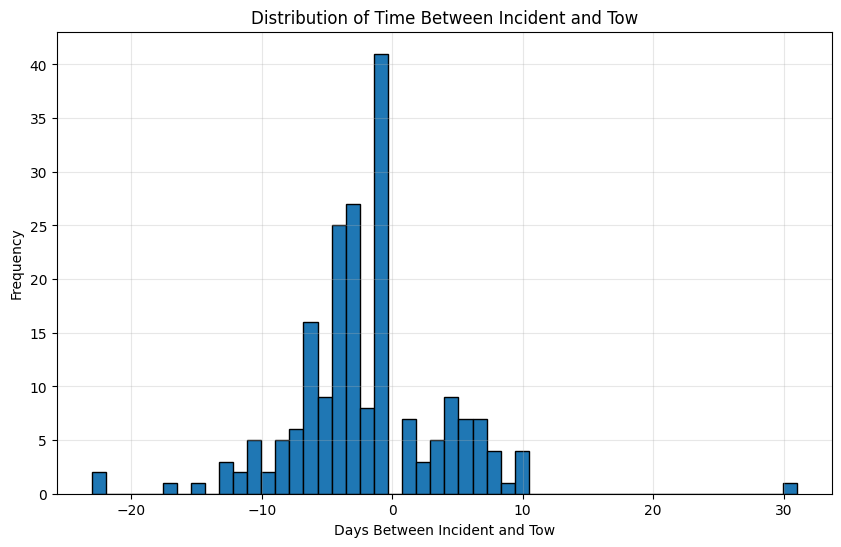

In [24]:
import matplotlib.pyplot as plt 

# Convert timedelta to numeric days
time_differences = tows['Difference'].dt.total_seconds() / (24 * 60 * 60)  # Convert to days

# Filter out zero values
non_zero = time_differences[time_differences != 0]

# Create the histogram
plt.figure(figsize=(10,6))
plt.hist(non_zero, bins=50, edgecolor='black')

# Add labels and title
plt.xlabel('Days Between Incident and Tow')
plt.ylabel('Frequency')
plt.title('Distribution of Time Between Incident and Tow')

plt.grid(True, alpha=0.3)

plt.show()

In [25]:
len(non_zero)

3256

In [14]:
tows.to_csv('tows.csv')

In [17]:
print(tows.iloc[48599])

Unnamed: 0                                                               48599
Tow Date                                                   2023-03-17 00:00:00
Vehicle Year                                                               NaN
Vehicle Make                                                              HYUN
Vehicle Model                                                              NaN
Tow Reason                                                       INVESTIGATION
Storage Company                                                            VRS
Notes                                                  AKJ TOWING  VRS 23-1195
Incident Date                                                              NaT
Location                                                      6571 COVENTRY LN
City                                                                   CLINTON
Geo-location field                                  POINT (-76.89313 38.78354)
coord                                               

In [18]:
tow_gdp_coords.to_csv('tow_coords_income.csv')

In [16]:
tows['City'].unique()

array(['SILVER SPRING', 'GAITHERSBURG', 'GERMANTOWN', 'ROCKVILLE',
       'BETHESDA', 'MONTGOMERY VILLAGE', 'CLARKSBURG', 'KENSINGTON',
       'TAKOMA PARK', 'BURTONSVILLE', 'CHEVY CHASE', 'DERWOOD', 'OLNEY',
       'POOLESVILLE', 'POTOMAC', 'DAMASCUS', nan, 'BELTSVILLE', 'MCLEAN',
       'BOYDS', 'BROOKEVILLE', 'CABIN JOHN', 'ASHTON', 'WASHINGTON',
       'DICKERSON', 'SANDY SPRING', 'HYATTSVILLE', 'LAUREL', 'VIENNA',
       'BELTSVILLE PG', 'HYATTSVILLE PG', 'CLINTON', 'DISTRICT HEIGHTS',
       'MT AIRY', 'SPENCERVILLE', 'BARNESVILLE', 'ALEXANDRIA',
       'GARRETT PARK'], dtype=object)

## Plots

### Number of tows over time

In [26]:
tows_time = tows.groupby(['Tow Date'], as_index=False).size()
tows24_time = tows24.groupby(['Tow Date'], as_index=False).size()
tows23_time = tows23.groupby(['Tow Date'], as_index=False).size()
tows22_time = tows22.groupby(['Tow Date'], as_index=False).size()

tows_time_comp = tows.groupby(['Tow Date', 'Trade Name'], as_index=False).size()

tows_reason = tows.groupby(['Reason for tow'], as_index=False).size()


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(tows24_time['Tow Date'], tows24_time['size'])
ax.set_xlabel('Time')
ax.set_ylabel('Number of tows')
plt.title('Number of Tows in Montgomery County')
plt.show

#### With November spike marked

In [ ]:
fig, ax = plt.subplots()

ax.plot(tows24_time['Tow Date'], tows24_time['size'])
plt.axvline(pd.to_datetime('2023-11-01'), color='grey')
plt.axvline(pd.to_datetime('2023-11-30'), color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Number of tows')
plt.title('Number of Tows in Montgomery County')
plt.show

#### Filter for November

In [13]:
november = tows24_time.loc[(tows24_time['Tow Date'] >= pd.to_datetime('2023-11-01')) 
                           & (tows24_time['Tow Date'] < pd.to_datetime('2023-12-01'))]

In [ ]:
fig, ax = plt.subplots()

ax.plot(november['Tow Date'], november['size'])
plt.axvline(pd.to_datetime('2023-11-23'), color='orange')
plt.xticks(rotation=90)
ax.set_xlabel('Time')
ax.set_ylabel('Number of tows')
plt.title('Number of Tows in Montgomery County')
plt.show

#### Check for seasonal patterns

In [ ]:
# First subplot
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
plt.plot(tows22_time['Tow Date'], tows22_time['size'], 'r-')  # red line
plt.title('2022 Financial Year')

# Second subplot
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(tows23_time['Tow Date'], tows23_time['size'], 'g-')  # green line
plt.title('2023 Financial Year')

# Third subplot
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(tows24_time['Tow Date'], tows24_time['size'], 'b-')  # blue line
plt.title('2024 Financial Year')

# Show the figure
plt.show()

### Tow Reason Bar Graph

In [14]:
tows24_reason = tows24.groupby(['Reason for tow'], as_index=False).size()

In [ ]:
fig, ax = plt.subplots()

ax.bar(tows24_reason['Reason for tow'], tows24_reason['size'])
plt.xticks(rotation=45)
ax.set_xlabel('Reason for tow')
ax.set_ylabel('Number of tows')
plt.suptitle('Number of Tows by Reason')
plt.title('Montgomery County, MD July 2023 - June 2024', fontsize='small')

plt.show()

## Plotly Dash

In [28]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

bar_fig = px.bar(tows_reason, x='Reason for tow', y='size', title='Number of Tows by Reason', color='Reason for tow')

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='bar-chart', figure=bar_fig),
    dcc.DatePickerRange(id='date-picker-range', min_date_allowed=pd.to_datetime('2022-07-01'),
                        max_date_allowed=pd.to_datetime('2024-06-30'), start_date=pd.to_datetime('2022-07-01'),
                        end_date=pd.to_datetime('2024-06-30')),
    dcc.Graph(id='line-chart')
])

@app.callback(
    Output('line-chart', 'figure'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_line_chart(start_date, end_date):
    filtered_line = tows_time_comp[(tows_time_comp['Tow Date'] >= start_date) &
                                 (tows_time_comp['Tow Date'] <= end_date)]
    
    line_fig = px.line(filtered_line, x='Tow Date', y='size', title='Number of Tows Over Time', color='Trade Name')
    return line_fig

app.run(jupyter_mode="tab")

app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


<IPython.core.display.Javascript object>

AssertionError: The setup method 'errorhandler' can no longer be called on the application. It has already handled its first request, any changes will not be applied consistently.
Make sure all imports, decorators, functions, etc. needed to set up the application are done before running it.

<function matplotlib.pyplot.show(close=None, block=None)>

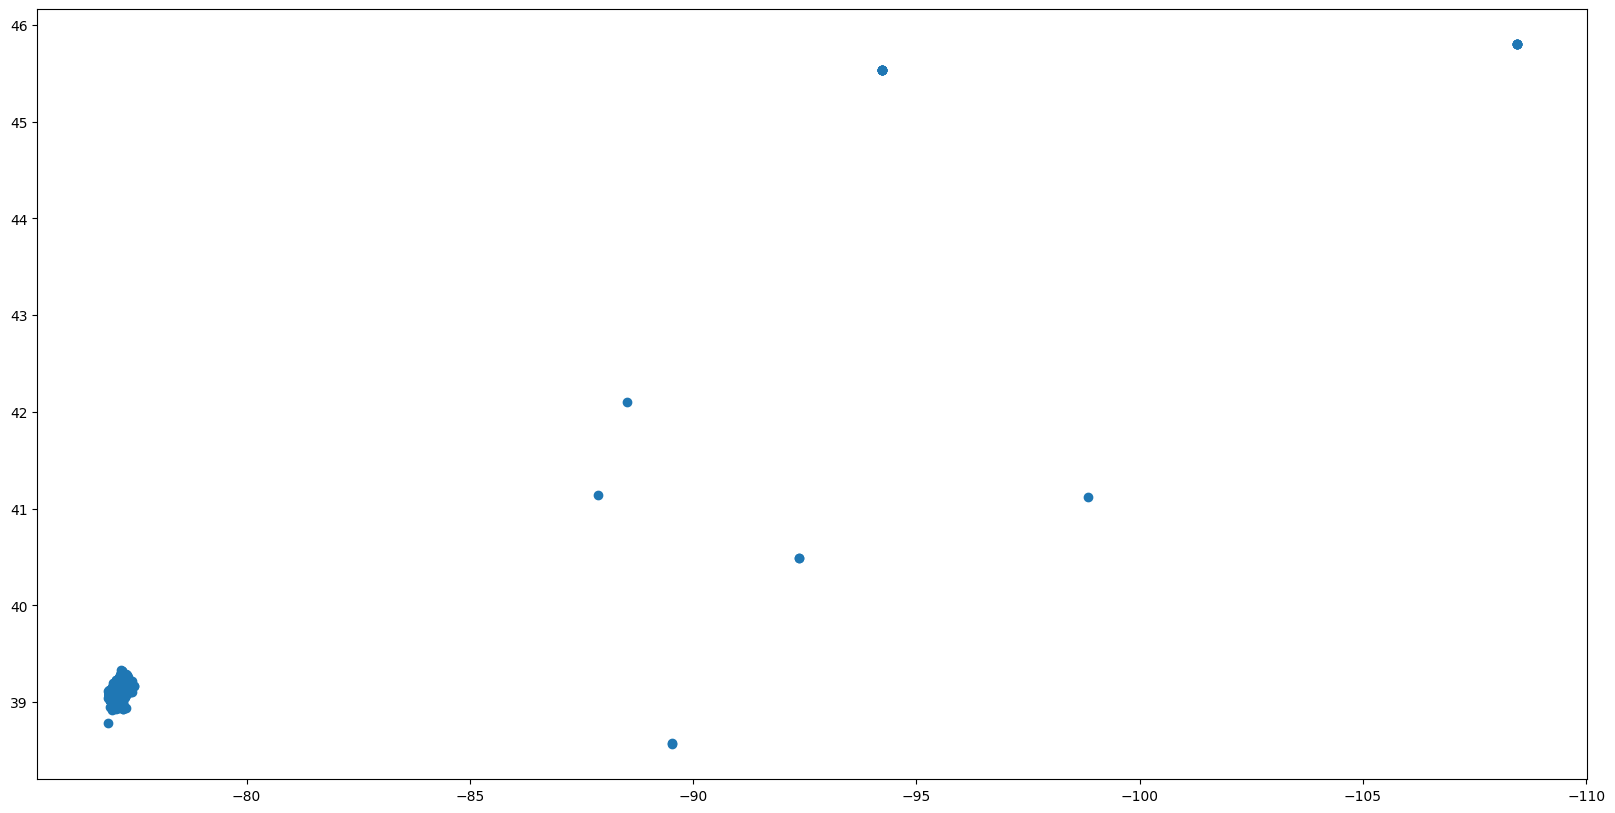

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(x= tows['lon'], y= tows['lat'])
plt.xlim((-76,-78))
plt.ylim((38,40))
plt.autoscale(enable=True, axis='both')
plt.show

In [20]:
tows.columns

Index(['Unnamed: 0', 'Tow Date', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Tow Reason', 'Storage Company', 'Notes',
       'Incident Date', 'Location', 'City', 'Geo-location field', 'coord',
       'lon', 'lat', 'geoid', 'TractFIPS', 'Reason for tow', 'Trade Name',
       'make', 'tract_only', 'state', 'county', 'fips_no_block',
       'median_household_income', 'foreign_born_population',
       'speak_only_english', 'total_population',
       'means_of_transportation_to_work_car_truck_or_van'],
      dtype='object')

In [21]:
tows = tows.drop(['Unnamed: 0', 'Tow Reason', 'Incident Date', 'Vehicle Make',
                  'Geo-location field', 'coord', 'geoid', 'Storage Company',
                  'TractFIPS', 'state', 'county', 'fips_no_block'], axis=1)

### Tow Lot Addresses

In [35]:
addresses = {"Henry's Wrecker Service": '8321 Beechcraft Avenue, Gaithersburg, MD 20879',
             'Authorized': '8011 Beechcraft Avenue, Gaithersburg, MD 20879',
             'Prestige': '13 Fedor Avenue, Gaithersburg, MD 20877',
             'Speedy Towing': '15101 Southlawn Lane, Rockville, MD 20850',
             'Metro Investigation & Recovery Solutions': '8595 Dorsey Run Road, Annapolis Junction, MD 20701'}

top_5_lots = pd.DataFrame.from_dict(addresses, orient='index').reset_index()
top_5_lots.columns = ['Merchant', 'Address']

In [36]:
from pygris.geocode import geocode

top_5_lots['lon'] = 0
top_5_lots['lat'] = 0

i = 0
while i < len(top_5_lots):
    try:
       top_5_lots.loc[i,'lon'] = geocode(address=top_5_lots.loc[i, 'Address']).iloc[0, 0]
       top_5_lots.loc[i,'lat'] = geocode(address=top_5_lots.loc[i, 'Address']).iloc[0, 1]
       print('yay' + str(i)) 
    except:
        pass
        print('oops' + str(i))
    i += 1

C:\Users\Home\AppData\Local\Temp\ipykernel_17640\1753694526.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-77.16982943587523' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  top_5_lots.loc[i,'lon'] = geocode(address=top_5_lots.loc[i, 'Address']).iloc[0, 0]
C:\Users\Home\AppData\Local\Temp\ipykernel_17640\1753694526.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.167950088780536' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  top_5_lots.loc[i,'lat'] = geocode(address=top_5_lots.loc[i, 'Address']).iloc[0, 1]


yay0
yay1
yay2
yay3
yay4
